In [ ]:
# @title Load and Prepare Data { display-mode: "form" }

# Cài thư viện cần thiết

!pip install yfinance
!pip install torch torch-geometric pandas numpy matplotlib scikit-learn -q
!pip install torch
!pip install torch-geometric
!pip install pandas numpy matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00


In [ ]:
# @title Dataset { display-mode: "form" }

import yfinance as yf
import pandas as pd
import numpy as np
import torch
import random

# Set random seed để cố định mọi kết quả
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Chọn 5 cổ phiếu lớn
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

# Tải dữ liệu 100 ngày gần nhất với giá điều chỉnh
data = yf.download(tickers, period="100d", interval="1d", group_by='ticker', auto_adjust=True)

# Tạo DataFrame đặc trưng
features = pd.DataFrame()

for ticker in tickers:
    df = data[ticker].copy()
    price = df['Close']

    features[f'{ticker}_price'] = price
    features[f'{ticker}_return'] = price.pct_change()
    features[f'{ticker}_ma5'] = price.rolling(window=5).mean()
    features[f'{ticker}_volatility'] = price.pct_change().rolling(window=5).std()

# Xử lý missing (do rolling và pct_change)
features = features.dropna().reset_index(drop=True)

# Lưu file
features.to_csv("simple_stock_dataset.csv", index=False)
print("Đã tạo file simple_stock_dataset.csv với đặc trưng cho 5 cổ phiếu.")


[*********************100%***********************]  5 of 5 completed


Đã tạo file simple_stock_dataset.csv với đặc trưng cho 5 cổ phiếu.


In [ ]:
# @title Data Preprocessing { display-mode: "form" }
import pandas as pd
import numpy as np

# Giả lập dữ liệu
np.random.seed(42)
num_days = 1000
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

df = pd.DataFrame({
    'AAPL': np.linspace(150, 170, num_days) + np.random.normal(0, 2, num_days),
    'MSFT': np.linspace(250, 270, num_days) + np.random.normal(0, 2, num_days),
    'GOOGL': np.linspace(100, 120, num_days) + np.random.normal(0, 2, num_days),
    'AMZN': np.linspace(90, 110, num_days) + np.random.normal(0, 2, num_days),
    'META': np.linspace(180, 200, num_days) + np.random.normal(0, 2, num_days)
})

# Thêm đặc trưng giả lập
for ticker in tickers:
    df[f"{ticker}_PE"] = np.random.uniform(10, 30, size=num_days)
    df[f"{ticker}_ROE"] = np.random.uniform(0.1, 0.3, size=num_days)
    df[f"{ticker}_Beta"] = np.random.uniform(0.8, 1.5, size=num_days)

# --- MÔ TẢ DỮ LIỆU ---
print("Cấu trúc dữ liệu:")
print(df.head())

print("\n Kích thước dữ liệu:", df.shape)

# Thống kê mô tả các giá cổ phiếu
print("\n Thống kê giá cổ phiếu:")
print(df[tickers].describe())

# Thống kê mô tả P/E
pe_cols = [f"{ticker}_PE" for ticker in tickers]
print("\n Thống kê đặc trưng P/E:")
print(df[pe_cols].describe())

# Tạo nhãn (label): giá AAPL hôm sau tăng?
aapl_price = df['AAPL'].values
label = (aapl_price[1:] > aapl_price[:-1]).astype(int)
print(f"\n Tỷ lệ AAPL tăng giá: {label.sum()}/{len(label)} = {label.mean():.2%}")


Cấu trúc dữ liệu:
         AAPL        MSFT      GOOGL       AMZN        META    AAPL_PE  \
0  150.993428  252.798711  98.649643  86.184385  178.273013  13.364732   
1  149.743491  251.869287  99.730983  88.299250  179.957613  13.798695   
2  151.335417  250.159301  98.455200  89.212829  180.076074  19.214243   
3  153.106120  248.766187  99.444137  93.835435  181.005321  15.725597   
4  149.611773  251.476527  96.292851  91.193186  177.346363  14.949260   

   AAPL_ROE  AAPL_Beta    MSFT_PE  MSFT_ROE  MSFT_Beta   GOOGL_PE  GOOGL_ROE  \
0  0.109956   1.458676  22.653541  0.150011   1.018859  13.766937   0.271275   
1  0.153700   1.140460  29.520279  0.183410   0.924763  20.009898   0.162003   
2  0.230847   1.123833  16.212019  0.170094   1.401428  25.864594   0.178550   
3  0.206723   1.349550  19.219392  0.271763   1.082466  13.003073   0.171311   
4  0.288808   1.375104  23.480027  0.125309   1.078981  23.194631   0.266571   

   GOOGL_Beta    AMZN_PE  AMZN_ROE  AMZN_Beta    META_PE

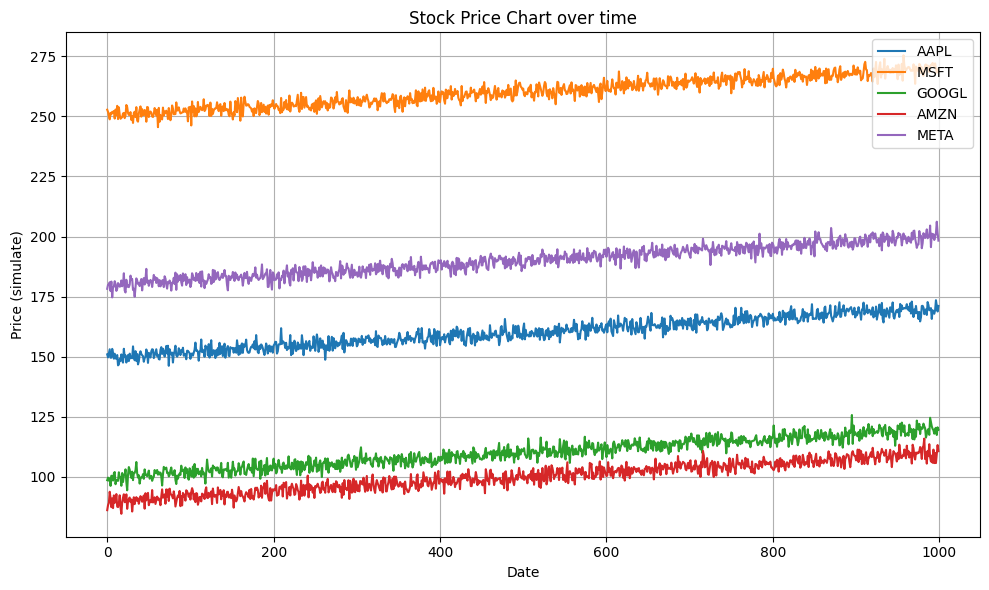

In [ ]:
# @title Stock Price Chart over time { display-mode: "form" }
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for ticker in ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']:
    plt.plot(df[ticker], label=ticker)
plt.title("Stock Price Chart over time")
plt.xlabel("Date")
plt.ylabel("Price (simulate)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-41-2070101427.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Stock")


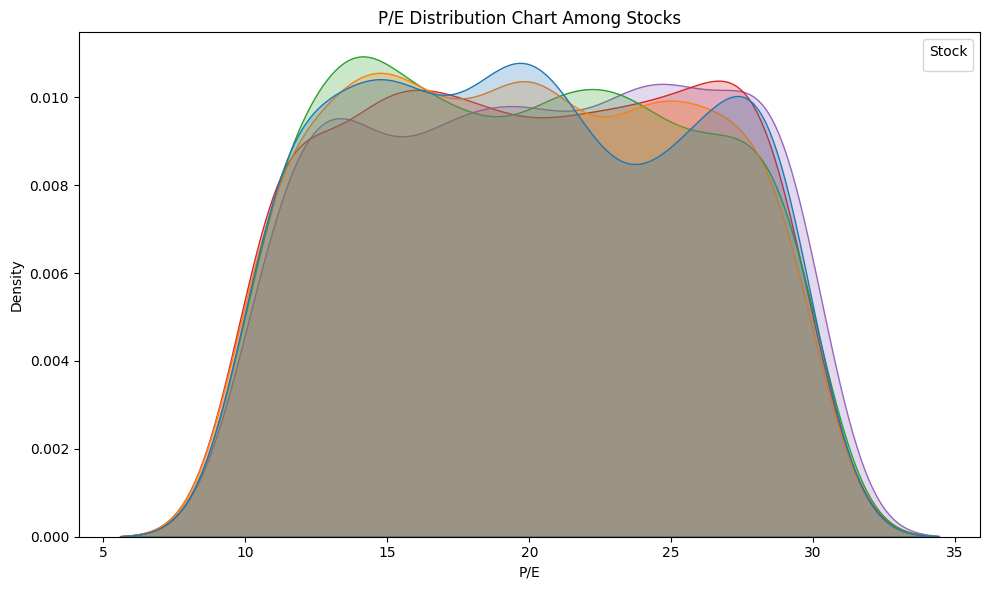

In [ ]:
# @title P/E Distribution Chart Among Stocks { display-mode: "form" }
import seaborn as sns
import pandas as pd
import numpy as np

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

# Gom về dạng dài
pe_df = pd.DataFrame({
    "P/E": np.concatenate([df[f"{ticker}_PE"].values for ticker in tickers]),
    "Stock": np.concatenate([[ticker] * len(df) for ticker in tickers])
})

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.kdeplot(data=pe_df, x="P/E", hue="Stock", fill=True)
plt.title("P/E Distribution Chart Among Stocks")
plt.xlabel("P/E")
plt.ylabel("Density")
plt.legend(title="Stock")
plt.tight_layout()
plt.show()

In [ ]:
# @title Data Object { display-mode: "form" }

import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data

# 1. Load CSV
df = pd.read_csv("simple_stock_dataset.csv")

# 2. Chuẩn hóa tất cả các đặc trưng
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df.values)
x = torch.tensor(x_scaled, dtype=torch.float)


num_stocks = int(x.shape[1] / 4)
edge_index = []
for i in range(num_stocks):
    for j in range(num_stocks):
        if i != j:
            edge_index.append([i, j])
edge_index = torch.tensor(edge_index).t().contiguous()  # shape [2, num_edges]

# 4. Tạo nhãn (label): dự đoán giá AAPL hôm sau tăng (1) hay giảm (0)
aapl_price = df.iloc[:, 0].values  # cột đầu tiên là AAPL_price
label = (torch.tensor(aapl_price[1:] > aapl_price[:-1])).long()  # Up=1, Down=0

# 5. Đồng bộ input với label (loại bỏ dòng cuối)
x = x[:-1]
y = label

# 6. Đóng gói vào PyG Data object
data = Data(x=x, edge_index=edge_index, y=y)

print("Tạo Data object thành công!")
print(f"Feature shape: {x.shape}")
print(f"Edge index shape: {edge_index.shape}")
print(f"Label shape: {y.shape}")


Tạo Data object thành công!
Feature shape: torch.Size([94, 20])
Edge index shape: torch.Size([2, 20])
Label shape: torch.Size([94])


In [ ]:
# @title Train model TGCN { display-mode: "form" }

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class TGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TGCN, self).__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.gru = nn.GRU(hidden_channels, hidden_channels, batch_first=True)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # GCN layer: apply on each day
        x = self.gcn(x, edge_index)
        x = F.relu(x)

        # Thêm chiều thời gian (giả lập): batch_size = x.size(0), seq_len = 1
        x = x.unsqueeze(1)

        # GRU layer
        _, h = self.gru(x)  # h shape: (1, batch, hidden)
        h = h.squeeze(0)

        # Fully connected
        out = self.fc(h)
        return out

# Cấu hình
in_channels = data.x.shape[1]
hidden_channels = 32
out_channels = 2  # Up / Down

model = TGCN(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train/Test Split
train_ratio = 0.8
num_train = int(len(data.x) * train_ratio)
train_x = data.x[:num_train]
train_y = data.y[:num_train]
test_x = data.x[num_train:]
test_y = data.y[num_train:]

# Huấn luyện
for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()
    out = model(train_x, data.edge_index)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        model.eval()
        pred = model(test_x, data.edge_index).argmax(dim=1)
        acc = (pred == test_y).float().mean().item()
        print(f"Epoch {epoch:02d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")

# Trước vòng lặp: khai báo list để lưu log
tgcn_loss_list = []
tgcn_acc_list = []

# Trong vòng lặp
for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()
    out = model(train_x, data.edge_index)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()

    # Đánh giá
    model.eval()
    pred = model(test_x, data.edge_index).argmax(dim=1)
    acc = (pred == test_y).float().mean().item()

    # Lưu loss + acc vào list
    tgcn_loss_list.append(loss.item())
    tgcn_acc_list.append(acc)

    # In ra nếu muốn
    if epoch % 10 == 0 or epoch == 1:
        print(f"[TGCN] Epoch {epoch:02d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")


Epoch 01 | Loss: 0.6935 | Test Acc: 0.4211
Epoch 10 | Loss: 0.4476 | Test Acc: 0.4211
Epoch 20 | Loss: 0.2595 | Test Acc: 0.4211
Epoch 30 | Loss: 0.1258 | Test Acc: 0.4211
Epoch 40 | Loss: 0.0742 | Test Acc: 0.4211
Epoch 50 | Loss: 0.0531 | Test Acc: 0.4211
[TGCN] Epoch 01 | Loss: 0.0519 | Test Acc: 0.4211
[TGCN] Epoch 10 | Loss: 0.0473 | Test Acc: 0.4211
[TGCN] Epoch 20 | Loss: 0.0465 | Test Acc: 0.4211
[TGCN] Epoch 30 | Loss: 0.0460 | Test Acc: 0.4211
[TGCN] Epoch 40 | Loss: 0.0458 | Test Acc: 0.4211
[TGCN] Epoch 50 | Loss: 0.0455 | Test Acc: 0.4211


In [ ]:
# @title Train model Attention - TGCN { display-mode: "form" }
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class AttentionTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(AttentionTGCN, self).__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.attention = nn.Linear(hidden_channels, 1)  # Attention score cho mỗi node
        self.gru = nn.GRU(hidden_channels, hidden_channels, batch_first=True)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # GCN
        x = self.gcn(x, edge_index)
        x = F.relu(x)

        # Attention: softmax over nodes (cổ phiếu)
        attn_weights = torch.softmax(self.attention(x), dim=0)  # shape: [num_nodes, 1]
        x = x * attn_weights  # nhân attention vào feature của node

        # GRU
        x = x.unsqueeze(1)  # simulate chuỗi thời gian
        _, h = self.gru(x)
        h = h.squeeze(0)

        out = self.fc(h)
        return out

model = AttentionTGCN(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()
    out = model(train_x, data.edge_index)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        model.eval()
        pred = model(test_x, data.edge_index).argmax(dim=1)
        acc = (pred == test_y).float().mean().item()
        print(f"[Attention-TGCN] Epoch {epoch:02d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")

# Trước vòng lặp: khai báo list để lưu log
attention_loss_list = []
attention_acc_list = []

# Trong vòng lặp
for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()
    out = model(train_x, data.edge_index)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()

    # Đánh giá
    model.eval()
    pred = model(test_x, data.edge_index).argmax(dim=1)
    acc = (pred == test_y).float().mean().item()

    # Lưu loss + acc vào list
    attention_loss_list.append(loss.item())
    attention_acc_list.append(acc)

    # In ra
    if epoch % 10 == 0 or epoch == 1:
        print(f"[TGCN] Epoch {epoch:02d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")


[Attention-TGCN] Epoch 01 | Loss: 0.6988 | Test Acc: 0.4211
[Attention-TGCN] Epoch 10 | Loss: 0.6867 | Test Acc: 0.5263
[Attention-TGCN] Epoch 20 | Loss: 0.6368 | Test Acc: 0.4737
[Attention-TGCN] Epoch 30 | Loss: 0.5332 | Test Acc: 0.4211
[Attention-TGCN] Epoch 40 | Loss: 0.4201 | Test Acc: 0.4211
[Attention-TGCN] Epoch 50 | Loss: 0.3211 | Test Acc: 0.4211
[TGCN] Epoch 01 | Loss: 0.3158 | Test Acc: 0.4737
[TGCN] Epoch 10 | Loss: 0.2611 | Test Acc: 0.4737
[TGCN] Epoch 20 | Loss: 0.2301 | Test Acc: 0.4737
[TGCN] Epoch 30 | Loss: 0.2011 | Test Acc: 0.4737
[TGCN] Epoch 40 | Loss: 0.1837 | Test Acc: 0.4737
[TGCN] Epoch 50 | Loss: 0.1766 | Test Acc: 0.5263


In [ ]:
# Tải lại dataset mini đã chuẩn hóa
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch

df = pd.read_csv("simple_stock_dataset.csv")

# Tạo thêm các đặc trưng giả lập
np.random.seed(42)
for ticker in ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']:
    df[f'{ticker}_PE'] = np.random.uniform(10, 30, size=len(df))
    df[f'{ticker}_ROE'] = np.random.uniform(0.1, 0.3, size=len(df))
    df[f'{ticker}_Beta'] = np.random.uniform(0.8, 1.5, size=len(df))

# Chuẩn hóa
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df.values)
x = torch.tensor(x_scaled, dtype=torch.float)

# Tạo label (giá AAPL tăng/giảm hôm sau)
aapl_price = df.iloc[:, 0].values
label = (torch.tensor(aapl_price[1:] > aapl_price[:-1])).long()
x = x[:-1]
y = label

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

class FeatureTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(FeatureTGCN, self).__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.gru = nn.GRU(hidden_channels, hidden_channels, batch_first=True)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.gcn(x, edge_index)
        x = F.relu(x)
        x = x.unsqueeze(1)
        _, h = self.gru(x)
        h = h.squeeze(0)
        out = self.fc(h)
        return out


# Dùng lại edge_index từ trước
edge_index = []
num_stocks = 5
for i in range(num_stocks):
    for j in range(num_stocks):
        if i != j:
            edge_index.append([i, j])
edge_index = torch.tensor(edge_index).t().contiguous()

# Tạo data object
data_feat = Data(x=x, edge_index=edge_index, y=y)

# Train/test split
train_x = data_feat.x[:int(0.8*len(x))]
train_y = data_feat.y[:int(0.8*len(y))]
test_x = data_feat.x[int(0.8*len(x)):]
test_y = data_feat.y[int(0.8*len(y)):]

# Train
model = FeatureTGCN(in_channels=x.shape[1], hidden_channels=32, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()
    out = model(train_x, edge_index)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        model.eval()
        pred = model(test_x, edge_index).argmax(dim=1)
        acc = (pred == test_y).float().mean().item()
        print(f"[Feature-TGCN] Epoch {epoch:02d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")


# Trước vòng lặp: khai báo list để lưu log
feat_loss_list = []
feat_acc_list = []

# Trong vòng lặp
for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()
    out = model(train_x, data.edge_index)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()

    # Đánh giá
    model.eval()
    pred = model(test_x, data.edge_index).argmax(dim=1)
    acc = (pred == test_y).float().mean().item()

    # Lưu loss + acc vào list
    feat_loss_list.append(loss.item())
    feat_acc_list.append(acc)

    # In ra
    if epoch % 10 == 0 or epoch == 1:
        print(f"[TGCN] Epoch {epoch:02d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")

[Feature-TGCN] Epoch 01 | Loss: 0.6977 | Test Acc: 0.3684
[Feature-TGCN] Epoch 10 | Loss: 0.3420 | Test Acc: 0.3158
[Feature-TGCN] Epoch 20 | Loss: 0.0569 | Test Acc: 0.2632
[Feature-TGCN] Epoch 30 | Loss: 0.0455 | Test Acc: 0.3684
[Feature-TGCN] Epoch 40 | Loss: 0.0452 | Test Acc: 0.3684
[Feature-TGCN] Epoch 50 | Loss: 0.0459 | Test Acc: 0.3684
[TGCN] Epoch 01 | Loss: 0.0449 | Test Acc: 0.3684
[TGCN] Epoch 10 | Loss: 0.0449 | Test Acc: 0.3684
[TGCN] Epoch 20 | Loss: 0.0449 | Test Acc: 0.3684
[TGCN] Epoch 30 | Loss: 0.0449 | Test Acc: 0.3684
[TGCN] Epoch 40 | Loss: 0.0449 | Test Acc: 0.3684
[TGCN] Epoch 50 | Loss: 0.0449 | Test Acc: 0.3684


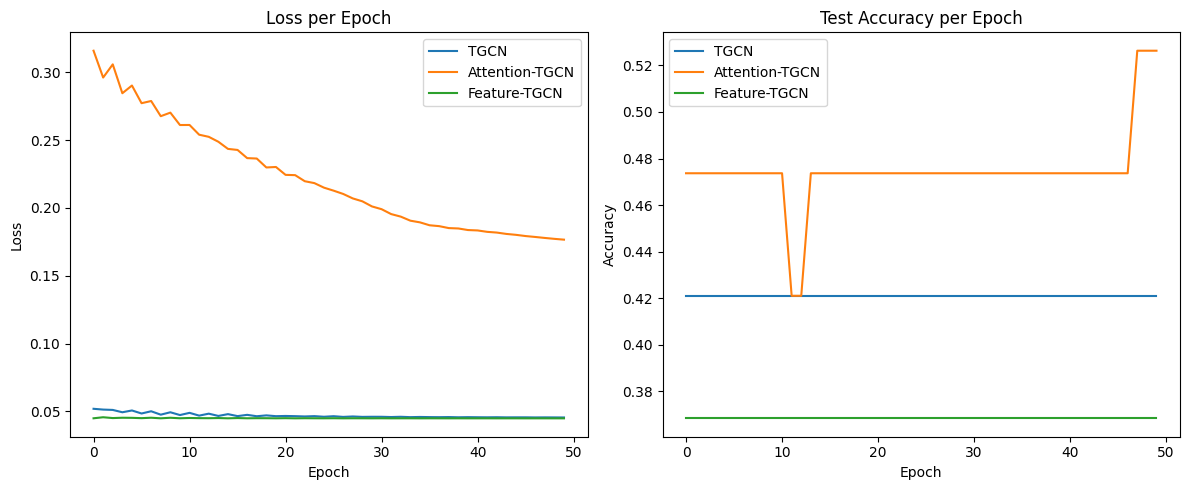

Final Test Accuracy:
TGCN:               0.4211
Attention-TGCN:     0.5263
Feature-TGCN:       0.3684


In [ ]:
# @title Loss and Accuracy { display-mode: "form" }
import matplotlib.pyplot as plt

# Biểu đồ Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(tgcn_loss_list, label="TGCN")
plt.plot(attention_loss_list, label="Attention-TGCN")
plt.plot(feat_loss_list, label="Feature-TGCN")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(tgcn_acc_list, label="TGCN")
plt.plot(attention_acc_list, label="Attention-TGCN")
plt.plot(feat_acc_list, label="Feature-TGCN")
plt.title("Test Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


print("Final Test Accuracy:")

print(f"TGCN:               {tgcn_acc_list[-1]:.4f}")
print(f"Attention-TGCN:     {attention_acc_list[-1]:.4f}")
print(f"Feature-TGCN:       {feat_acc_list[-1]:.4f}")

In [ ]:
# @title Prediction { display-mode: "form" }
import torch.nn.functional as F

# Dùng lại đúng data lúc train
x_all = data_feat.x
edge_index = data_feat.edge_index

# Dự đoán
model.eval()
with torch.no_grad():
    output = model(x_all, edge_index)

# Dự đoán node AAPL (ví dụ node 0)
aapl_output = output[0]
prob = F.softmax(aapl_output, dim=0)
up_prob = prob[1].item()

print(x_all.shape)

print("[Feature-TGCN] Dự đoán cho ngày tiếp theo:")
print(f"Xác suất AAPL tăng giá: {up_prob:.4f}")
if up_prob > 0.5:
    print("Gợi ý: NÊN đầu tư vào AAPL. (Apple)")
else:
    print("Gợi ý: KHÔNG nên đầu tư vào AAPL.(Apple)")


torch.Size([94, 35])
[Feature-TGCN] Dự đoán cho ngày tiếp theo:
Xác suất AAPL tăng giá: 0.5932
Gợi ý: NÊN đầu tư vào AAPL. (Apple)
